In [34]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys

# Add the project directory to sys.path
project_dir = Path.cwd().parent  # Adjust as needed to point to your project root
sys.path.append(str(project_dir))

print("project_dir: ", project_dir)
from utils.pipeline_fixed import Pipeline, EvaluationEnum

dataloader = Pipeline(evaluation=EvaluationEnum.BALANCE)

file_tag = "economical"
eval_metric = "f1"

trnX, tstX, trnY, tstY, target, labels = dataloader.get_economical_classification_train_test()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
project_dir:  /Users/hugojarudd/Desktop/kdd-process/src


In [35]:
from pandas import DataFrame, Index, read_csv
from dslabs_functions import (
    select_low_variance_variables,
    study_variance_for_feature_selection,
    apply_feature_selection,
    select_redundant_variables,
    study_redundancy_for_feature_selection,
)
from pandas import Series, DataFrame
from math import ceil
from matplotlib.pyplot import savefig, show, figure
from dslabs_functions import HEIGHT, evaluate_approach, plot_multiline_chart
import pandas as pd
from sklearn.model_selection import train_test_split


## Train test split


In [36]:
train = pd.concat([trnX, trnY], axis=1)
test = pd.concat([tstX, tstY], axis=1)

# Correlation analysis

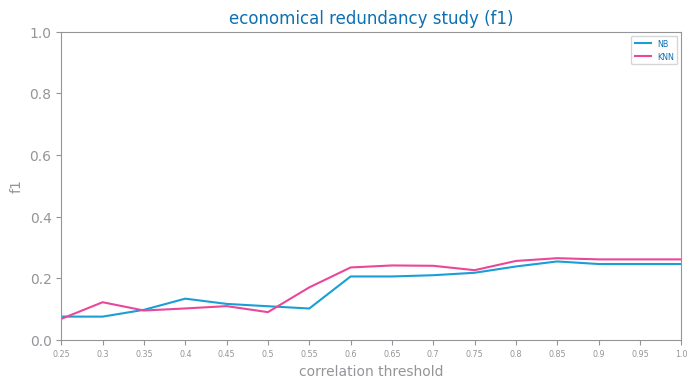

In [37]:
def study_redundancy_for_feature_selection(
    train: DataFrame,
    test: DataFrame,
    target: str = "CLASS",
    min_threshold: float = 0.90,
    lag: float = 0.05,
    metric: str = "accuracy",
    file_tag: str = "",
) -> dict:
    options: list[float] = [
        round(min_threshold + i * lag, 3)
        for i in range(ceil((1 - min_threshold) / lag) + 1)
    ]

    df: DataFrame = train.drop(target, axis=1, inplace=False)
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    results: dict[str, list] = {"NB": [], "KNN": []}
    for thresh in options:
        vars2drop: list = []
        for v1 in variables:
            vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= thresh]
            vars_corr.drop(v1, inplace=True)
            if len(vars_corr) > 1:
                lst_corr = list(vars_corr.index)
                for v2 in lst_corr:
                    if v2 not in vars2drop:
                        vars2drop.append(v2)

        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
        eval: dict | None = evaluate_approach(
            train_copy, test_copy, target=target, metric=metric
        )
        if eval is not None:
            results["NB"].append(eval[metric][0])
            results["KNN"].append(eval[metric][1])

    plot_multiline_chart(
        options,
        results,
        title=f"{file_tag} redundancy study ({metric})",
        xlabel="correlation threshold",
        ylabel=metric,
        percentage=True,
    )
    savefig(f"images/{file_tag}_fs_redundancy_{metric}_study.png")
    return results


eval_metric = "f1"

figure(figsize=(2 * HEIGHT, HEIGHT))
study_redundancy_for_feature_selection(
    train,
    test,
    target=target,
    min_threshold=0.25,
    lag=0.05,
    metric=eval_metric,
    file_tag=file_tag,
)
show()


 From the graph above it can be seen that dropping variables with correlation higher than 0.85 is beneficial for both models

In [38]:
def select_redundant_variables(
    data: DataFrame, min_threshold: float = 0.90, target: str = "class"
) -> list:
    df: DataFrame = data.drop(target, axis=1, inplace=False)
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    vars2drop: list = []
    for v1 in variables:
        vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= min_threshold]
        vars_corr.drop(v1, inplace=True)
        if len(vars_corr) > 1:
            lst_corr = list(vars_corr.index)
            for v2 in lst_corr:
                if v2 not in vars2drop:
                    vars2drop.append(v2)
    return vars2drop


print("Original variables", train.columns.values)
vars2drop_corr: list[str] = select_redundant_variables(
    train, target=target, min_threshold=0.85
)
print("Variables to drop", sorted(vars2drop_corr))

Original variables ['Company' 'Time' 'x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x8' 'x9' 'x10' 'x11'
 'x12' 'x14' 'x15' 'x16' 'x17' 'x18' 'x19' 'x20' 'x21' 'x22' 'x23' 'x24'
 'x25' 'x26' 'x27' 'x28' 'x29' 'x30' 'x31' 'x32' 'x35' 'x36' 'x37' 'x39'
 'x40' 'x41' 'x42' 'x43' 'x44' 'x45' 'x46' 'x47' 'x51' 'x54' 'x55' 'x56'
 'x57' 'x58' 'x59' 'x60' 'x61' 'x63' 'x64' 'x65' 'x66' 'x67' 'x68' 'x69'
 'x70' 'x71' 'x72' 'x73' 'x74' 'x78' 'x80' 'x82' 'x83' 'CLASS']
Variables to drop ['x64', 'x68']


In [39]:
trnX = trnX.drop(columns=vars2drop_corr)
tstX = tstX.drop(columns=vars2drop_corr)

# Variability analysis

In [40]:
from pandas import DataFrame, Index, read_csv
from dslabs_functions import (
    select_low_variance_variables,
    study_variance_for_feature_selection,
    apply_feature_selection,
    select_redundant_variables,
    study_redundancy_for_feature_selection,
)


def select_low_variance_variables(
    data: DataFrame, max_threshold: float, target: str = "CLASS"
) -> list:
    summary5: DataFrame = data.describe()
    vars2drop: Index[str] = summary5.columns[
        summary5.loc["std"] * summary5.loc["std"] < max_threshold
    ]
    vars2drop = vars2drop.drop(target) if target in vars2drop else vars2drop
    return list(vars2drop.values)



print("Original variables", train.columns.to_list())
vars2drop_var: list[str] = select_low_variance_variables(train, 0.7, target=target)
print("Variables to drop", vars2drop_var)

Original variables ['Company', 'Time', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x8', 'x9', 'x10', 'x11', 'x12', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x35', 'x36', 'x37', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x51', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73', 'x74', 'x78', 'x80', 'x82', 'x83', 'CLASS']


Variables to drop ['x1', 'x12', 'x15', 'x17', 'x18', 'x20', 'x21', 'x22', 'x25', 'x27', 'x31', 'x35', 'x39', 'x43', 'x44', 'x46', 'x54', 'x57']


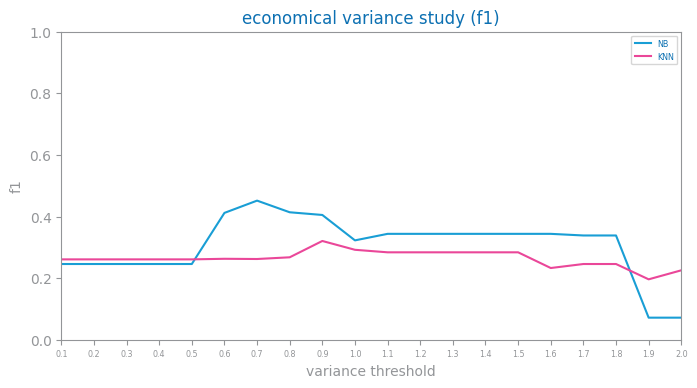

In [41]:
from math import ceil
from matplotlib.pyplot import savefig, show, figure
from dslabs_functions import HEIGHT, evaluate_approach, plot_multiline_chart


def study_variance_for_feature_selection(
    train: DataFrame,
    test: DataFrame,
    target: str = "CLASS",
    max_threshold: float = 1,
    lag: float = 0.05,
    metric: str = "accuracy",
    file_tag: str = "",
) -> dict:
    options: list[float] = [
        round(i * lag, 3) for i in range(1, ceil(max_threshold / lag + lag))
    ]
    results: dict[str, list] = {"NB": [], "KNN": []}
    summary5: DataFrame = train.describe()
    for thresh in options:
        vars2drop: Index[str] = summary5.columns[
            summary5.loc["std"] * summary5.loc["std"] < thresh
        ]
        vars2drop = vars2drop.drop(target) if target in vars2drop else vars2drop

        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
        eval: dict[str, list] | None = evaluate_approach(
            train_copy, test_copy, target=target, metric=metric
        )
        if eval is not None:
            results["NB"].append(eval[metric][0])
            results["KNN"].append(eval[metric][1])

    plot_multiline_chart(
        options,
        results,
        title=f"{file_tag} variance study ({metric})",
        xlabel="variance threshold",
        ylabel=metric,
        percentage=True,
    )
    savefig(f"images/{file_tag}_fs_low_var_{metric}_study.png")
    return results


eval_metric = "f1"


figure(figsize=(2 * HEIGHT, HEIGHT))
study_variance_for_feature_selection(
    train,
    test,
    target=target,
    max_threshold=2,
    lag=0.1,
    metric=eval_metric,
    file_tag=file_tag,
)
show()


Since there's a peak in the performance of NB at 0.7 and KNN isn't affecrted, variables with lower variance than 0.7 will be dropped.